In [86]:
import json
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from scipy.stats.kde import gaussian_kde
import scipy.signal as signal
%matplotlib inline
from IPython.html import widgets
from IPython.html.widgets import interact,fixed

from utils import \
    maybe_get_model,\
    persist_widget_value
    
from toolz import curry

In [87]:
model_filepath = '/notebooks/tmp/threshold-ui-model.json'
uiget = maybe_get_model(model_filepath) # key -> value
uiset = persist_widget_value(model_filepath) # widget -> key

In [102]:
# String -> String
def from_file(filename):
    """ Return contents of selected file. """
    f = open(filename)
    data = f.read()
    f.close()
    return data

# String -> String -> SideEffect[File]
def to_file(filename,content):
    f = open(filename,'w+')
    f.write(content)
    f.close()   
    
# String -> String -> Float -> SideEffect[File]
def save_temp_threshold(condition,threshold):
    """ Save threshold (for specific condition) to file.
        This temp file will be read and merged with persistent file
         when save button is clicked. """
    data = {'Condition': condition,
            'Threshold': threshold}
    to_file('/notebooks/tmp/temp_threshold.json',json.dumps(data))
    
# String -> SideEffect[File]
def save_threshold(threshold_file):
    """ Given filepath to csv containing thresholds, 
        mutate the values based on the temporary threshold file. """
    temp_file = '/notebooks/tmp/temp_threshold.json'
    temp_threshold = json.loads(from_file(temp_file))
    thresholds = pd.read_csv(threshold_file)
    thresholds = thresholds.set_index('Condition')
    
    condition = temp_threshold['Condition']
    threshold = temp_threshold['Threshold']
    
    thresholds.loc[condition] = threshold
    thresholds = thresholds.reset_index()
    thresholds.to_csv(threshold_file,index=False)

In [89]:
execfile('/notebooks/assay-explorer/src/display_utils.py')

In [90]:
filepaths = {'ssC drug data': '/notebooks/moldev-data/analyzed/07-20-2015/ssC-cells.csv',
             'APB drug data': '/notebooks/moldev-data/analyzed/07-20-2015/APB-cells.csv'}
threshold_filepaths = {'ssC drug data': '/notebooks/moldev-data/analyzed/07-20-2015/ssC-thresholds.csv',
                       'APB drug data': '/notebooks/moldev-data/analyzed/07-20-2015/APB-thresholds.csv'}

In [91]:
mydataset = widgets.Dropdown(options=['ssC drug data','APB drug data'],
                             value = uiget('filename','ssC drug data'))
uiset(mydataset,'filename')

# Select dataset
Click `Cell > Run All` in the menu above to update the dataset shown.

In [92]:
mydataset

In [93]:
filepath = filepaths[mydataset.value]
threshold_filepath = threshold_filepaths[mydataset.value]

In [94]:
cells = pd.read_csv(filepath)

In [95]:
# [Float] -> Float
def get_threshold(intensity,bw = 0.35):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,bw)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold

In [96]:
# Create dummy file with thresholds
def get_threshold_from_group(group):
    groupname = group[0]
    groupdata = group[1]
    intensities = groupdata['NucIntegrated Intensity_Avg']
    return {'Condition': groupname,
            'Threshold': get_threshold(intensities,0.5)}

if not os.path.isfile(threshold_filepath):
    condition_groups = cells.groupby('Condition')
    initial_thresholds = pd.DataFrame(map(get_threshold_from_group,condition_groups))
    initial_thresholds.to_csv(threshold_filepath,index=False)

In [97]:
# [Num] -> Float -> SideEffect[Plot]
def plot_gaussian_kde(X,bw,color='k',alpha=1):
    kde_fit = gaussian_kde(X,bw)
    x = np.linspace(min(X),
                    max(X),
                    1000)
    y = kde_fit(x)
    plt.plot(x,y,color=color,alpha = alpha)

In [98]:
def determine_thresholding_parameters \
(data,condition,other_condition,smoothness,manually_set_threshold,show):
    bw = smoothness
    method = show
    intensities = data[data['Condition'] == condition]['NucIntegrated Intensity_Avg']
    
    plot_gaussian_kde(intensities,bw,color='r')
    plt.title(condition)
    plt.xlim(0,1.5e8)
    plt.ylim(0,5.5e-8)
    plt.xlabel('NucIntegrated Intensity_Avg')
    
    # Plot thresholds
    auto_threshold = get_threshold(intensities,bw)
    threshold_data = pd.read_csv(threshold_filepath)
    other_conditions_threshold = threshold_data[threshold_data['Condition'] == other_condition]['Threshold'].values.tolist()[0]
    saved_threshold = threshold_data[threshold_data['Condition'] == condition]['Threshold'].values.tolist()[0]
    
    lw = 3
    alpha = 0.3
    
    if method == 'Auto':
        plt.plot([auto_threshold,auto_threshold],plt.gca().get_ylim(),color = 'r',linewidth = lw,alpha = alpha,label='Auto')
        save_temp_threshold(condition,auto_threshold)
    elif method == 'Manual':
        plt.plot([manually_set_threshold,manually_set_threshold],plt.gca().get_ylim(),color='g',linewidth = lw,alpha = alpha,label='Manual')
        save_temp_threshold(condition,manually_set_threshold)
    elif method == 'Other Condition':
        other_intensities = data[data['Condition'] == other_condition]['NucIntegrated Intensity_Avg']
        plot_gaussian_kde(other_intensities,bw,color='b',alpha=0.5)
        plt.plot([other_conditions_threshold,other_conditions_threshold],plt.gca().get_ylim(),color='b',linewidth = lw,alpha = alpha,label='Other Condition')
        save_temp_threshold(condition,other_conditions_threshold)
    elif method == 'Saved Value':
        plt.plot([saved_threshold,saved_threshold],plt.gca().get_ylim(),color='k',linewidth = lw,alpha = alpha,label='Saved Value')
        save_temp_threshold(condition,saved_threshold)
    
    plt.legend()   

# Cell Phase Separation

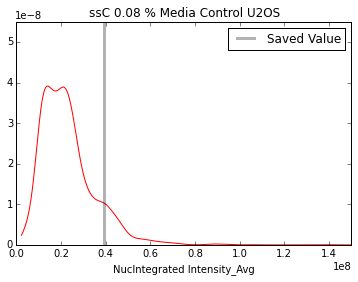

In [99]:
n_conditions = len(cells['Condition'].unique())
bw = {'min':0.025, 'max': 0.8, 'step':0.025}
intensities = cells['NucIntegrated Intensity_Avg']
thresh = {'min': intensities.min(),
          'max': intensities.max(),
          'step': (intensities.max() - intensities.min())/200,
          'init': intensities.median()}

interact(
    determine_thresholding_parameters,
    data = fixed(cells),
    condition = widgets.Dropdown(options = cells['Condition'].unique().tolist()),
    other_condition = widgets.Dropdown(options = cells['Condition'].unique().tolist()),
    smoothness = widgets.FloatSlider(min = bw['min'], max = bw['max'], step = bw['step']),
    manually_set_threshold = widgets.FloatSlider(min = thresh['min'], max = thresh['max'], step = thresh['step'],value=thresh['init']),
    show = widgets.ToggleButtons(options=['Manual','Auto','Other Condition','Saved Value']));


In [105]:
save_button = widgets.Button(description='Save Threshold')

def save_my_threshold(_):
    save_threshold(threshold_filepath)
save_button.on_click(save_my_threshold)

In [106]:
save_button